In [5]:
from requests import get, post
import json
import time
import pandas as pd
import os
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp

from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import Query

In [88]:
# all queries pull reward numbers in cumulative fashion! (fees in daily/single values)
# Rewards article uses df_monthly_data created at the very end of this notebook
# 4 steps to get there:
# 1) Pull data from dune via API (or import as csv)
# 2) Get split of rewards indexers and delegations and group output by indexer (df_indexer_all) and indexer&date (df_indexer_data_all)
#    dataframes include fees and other information beyond token rewards for later analysis
# 3) Aggregate data on daily timeseries df_indexer_days (incl. $-price data)
# 4) Aggregate daily timeseries to monthly data (output see csvs folder)

In [2]:
def get_rolling_avg(series,window):
    out=[]
    for i in range(0,len(series)):
        if i<window:
            if i==0:
                out.append(series[i])
            else:
                out.append(np.mean(series[:i]))
        else:
            out.append(np.mean(series[i-window:i]))
    return out

In [3]:
def convert_blocktime(blocktime, **kwargs):
    delta = kwargs.get('delta',6)
    if blocktime is None:
        return None
    else:
        timestr = blocktime.replace('T',' ').replace('Z','')
        return datetime.strptime(timestr[:-delta], "%Y-%m-%d %H:%M:%S")

In [86]:
#from https://dune.com/docs/api/quick-start/api-py/
BASE_URL = "https://api.dune.com/api/v1/"

def make_api_url(module, action, ID):
    """
    We shall use this function to generate a URL to call the API.
    """

    url = BASE_URL + module + "/" + str(ID) + "/" + action

    return url

def execute_query(query_id, engine="medium"):
    """
    Takes in the query ID and engine size.
    Specifying the engine size will change how quickly your query runs. 
    The default is "medium" which spends 10 credits, while "large" spends 20 credits.
    Calls the API to execute the query.
    Returns the execution ID of the instance which is executing the query.
    """

    url = make_api_url("query", "execute", query_id)
    params = {
        "performance": engine,
    }
    response = post(url, headers=HEADER, params=params)
    execution_id = response.json()['execution_id']

    return execution_id


def execute_query_with_params(query_id, param_dict):
    """
    Takes in the query ID. And a dictionary containing parameter values.
    Calls the API to execute the query.
    Returns the execution ID of the instance which is executing the query.
    """

    url = make_api_url("query", "execute", query_id)
    response = post(url, headers=HEADER, json={"query_parameters" : param_dict})
    execution_id = response.json()['execution_id']

    return execution_id


def get_query_status(execution_id):
    """
    Takes in an execution ID.
    Fetches the status of query execution using the API
    Returns the status response object
    """

    url = make_api_url("execution", "status", execution_id)
    response = get(url, headers=HEADER)

    return response


def get_query_results(execution_id):
    """
    Takes in an execution ID.
    Fetches the results returned from the query using the API
    Returns the results response object
    """

    url = make_api_url("execution", "results", execution_id)
    response = get(url, headers=HEADER)

    return response


def cancel_query_execution(execution_id):
    """
    Takes in an execution ID.
    Cancels the ongoing execution of the query.
    Returns the response object.
    """

    url = make_api_url("execution", "cancel", execution_id)
    response = get(url, headers=HEADER)

    return response

def run_query(query_id,**kwargs):
    parameters = kwargs.get('parameters',{})
    status_ping_interval = kwargs.get('status_ping_interval',30)
    query_size = kwargs.get('query_size','medium')
    if len(parameters)>0:
        execution_id = execute_query_with_params(query_id,parameters)
    else:
        execution_id = execute_query(query_id,query_size)
    
    # response = get_query_results(execution_id)
    status = get_query_status(execution_id)
    timesum=0
    while (status.json()['state'] == 'QUERY_STATE_EXECUTING') & (timesum<3600):
        print("Waiting for query to finish...")
        time.sleep(status_ping_interval)
        timesum+=status_ping_interval
        status = get_query_status(execution_id)
    
    response = get_query_results(execution_id)
    if response.json()['state'] == 'QUERY_STATE_COMPLETED':
        return pd.DataFrame(response.json()['result']['rows'])
    else:
        print(response.json()['state'])
        print('No output')
        return None

In [87]:
api_key='' # enter dune api key 

HEADER = {"x-dune-api-key" : api_key}
#to filter for timeranges 
start_date_rewards = datetime.strptime('2020-10-30','%Y-%m-%d')
end_date_rewards=datetime.strptime('2023-04-30','%Y-%m-%d')


In [55]:
#query ids, see also links_and_sources.md for direct dune links (e.g. for csv downloads)
indexer_balances_id = 1763641 #date and GRT of stake and delegate data per indexer
grt_fees_id=1838336 #date and GRT of query and curation fees per indexer
rewards_restaked_id = 1857084 #list of indexers and date that restake GRT
indexer_tx_logs = 1844721 #to pull reward data for indexers, start-date hardcoded in query, worth cutting this in shorter timeframes to avoid timeouts
epoch_data_id=1853711 #map epochs and dates

In [34]:
#index rewards, 573m GRT by end of 2022
#see eth logs below to get most rewardsAssigned, this is just to get early rewards taht have been automatically restaked
df_indexer_rewards_staked=run_query(rewards_restaked_id)
df_indexer_rewards_staked['datestr']=[convert_blocktime(df_indexer_rewards_staked.dateday.iloc[i], delta=1) for i in range(0,len(df_indexer_rewards_staked)) ]
df_indexer_rewards_staked['description']='transfer_index_staked'
df_indexer_rewards_staked['index']=0
df_indexer_rewards_staked['data']='0x'


Waiting for query to finish...


In [ ]:
# df_indexer_rewards_staked.to_pickle('df_indexer_rewards_staked.pkl')
# df_indexer_rewards_staked=pd.read_pickle('df_indexer_rewards_staked.pkl')

In [36]:
#date and GRT of query and curation fees per indexer (1.8m GRT by end of 2022)
df_index_fees = run_query(grt_fees_id)
df_index_fees['datestr']=[convert_blocktime(df_index_fees.dateday.iloc[i], delta=8) for i in range(0,len(df_index_fees)) ]

Waiting for query to finish...


In [ ]:
# df_index_fees.to_pickle('df_index_fees.pkl')

In [43]:
#stake and delegate data per indexer per date
df_indexer_data=run_query(indexer_balances_id)
df_indexer_data['datestr'] = [datetime.strptime(df_indexer_data.dateday.iloc[i],'%Y-%m-%d') for i in range(0,len(df_indexer_data)) ]
df_indexer_data=df_indexer_data.sort_values(by=['indexer','datestr']).reset_index()



In [44]:
df_indexer_data

,index,dateday,delegation_balance,delegator_reward,indexer,num_delegator,stake_balance,datestr
0,0,2023-01-07,0.0,0.0,0x0111d340a2611d772bc2b9fb6bcc61a858476604,0,100000.000000,2023-01-07
1,1,2023-01-08,0.0,0.0,0x0111d340a2611d772bc2b9fb6bcc61a858476604,0,100000.000000,2023-01-08
2,2,2023-01-09,0.0,0.0,0x0111d340a2611d772bc2b9fb6bcc61a858476604,0,100000.000000,2023-01-09
3,3,2023-01-10,0.0,0.0,0x0111d340a2611d772bc2b9fb6bcc61a858476604,0,100000.000000,2023-01-10
4,4,2023-01-11,0.0,0.0,0x0111d340a2611d772bc2b9fb6bcc61a858476604,0,100000.000000,2023-01-11
...,...,...,...,...,...,...,...,...
223110,223110,2023-04-30,0.0,0.0,0xff061dccea6548025306165adf8470fa5e978229,0,101099.664404,2023-04-30
223111,223111,2023-05-01,0.0,0.0,0xff061dccea6548025306165adf8470fa5e978229,0,101099.664404,2023-05-01
223112,223112,2023-05-02,0.0,0.0,0xff061dccea6548025306165adf8470fa5e978229,0,101099.664404,2023-05-02
223113,223113,2023-05-03,0.0,0.0,0xff061dccea6548025306165adf8470fa5e978229,0,101099.664404,2023-05-03


In [ ]:
# df_indexer_data.to_pickle('df_indexer_data.pkl')
# df_indexer_data = pd.read_pickle('df_indexer_data_grt.pkl')


In [28]:
# group indexer fees by indexer - feel free to ignore weighted averages
weight_duration = lambda x: np.average(x, weights = df_index_fees.loc[x.index,'sum_allocation_duration'])
weight_allocation = lambda x: np.average(x, weights = df_index_fees.loc[x.index,'tokens_at_creation'])

df_index_fees['is_curator_reward']=0
df_index_fees['duration_per_allocation']=df_index_fees.sum_allocation_duration/df_index_fees.num_allocations
df_index_fees.loc[df_index_fees.curation_fees>0,'is_curator_reward'] = df_index_fees[df_index_fees.curation_fees>0].num_queries

df_indexer_fees_tmp = df_index_fees[(df_index_fees.datestr>start_date_rewards)&(df_index_fees.datestr<end_date_rewards)].groupby('indexer').agg(
    max_date = ('datestr','max'),
    sum_rebate_fees = ('rebate_fees','sum'),
    num_queries = ('num_queries','sum'),
    sum_curation_fees = ('curation_fees','sum'),
    sum_query_fees = ('query_fees','sum'),
    sum_curated_queries = ('is_curator_reward','sum'),
    num_allocations = ('num_allocations','sum'),
    allocation_duration = ('sum_allocation_duration','sum'),
    sum_allocated_tokens = ('tokens_at_creation','sum'),
    # time_weight_allocated_tokens = ('tokens_at_creation',weight_duration),
    allocation_weight_duration = ('sum_allocation_duration',weight_allocation),
    min_date = ('datestr','min')
).reset_index()

df_indexer_fees_tmp['avg_allocation']=df_indexer_fees_tmp.sum_allocated_tokens/df_indexer_fees_tmp.num_allocations
df_indexer_fees_tmp['weighted_duration']=df_indexer_fees_tmp.allocation_weight_duration /df_indexer_fees_tmp.num_allocations
df_indexer_fees_tmp['avg_duration']=df_indexer_fees_tmp.allocation_duration /df_indexer_fees_tmp.num_allocations
df_indexer_fees_tmp2=df_index_fees[df_index_fees.indexer.isin(df_indexer_fees_tmp[df_indexer_fees_tmp.allocation_duration>0].indexer.unique())].groupby('indexer').agg(
    time_weight_allocated_tokens = ('tokens_at_creation',weight_duration)
)

df_indexer_fees_grp=df_indexer_fees_tmp.merge(df_indexer_fees_tmp2, how='inner',left_on='indexer', right_on='indexer').reset_index()
df_indexer_fees_grp['weighted_allocation']=df_indexer_fees_grp.time_weight_allocated_tokens/df_indexer_fees_tmp.num_allocations

df_indexer_fees_grp['days_start']=[int((datetime.now()-df_indexer_fees_grp.min_date.iloc[i]).days) for i in range(0,len(df_indexer_fees_grp))]
df_indexer_fees_grp['sum_fees']=df_indexer_fees_grp.sum_rebate_fees+df_indexer_fees_grp.sum_curation_fees
df_indexer_fees_grp['rank_fees']=df_indexer_fees_grp.sum_fees.rank(ascending=False)

In [154]:
df_indexer_fees_grp.sort_values(by='rank_fees')

,index,indexer,max_date,sum_query_fees,num_queries,sum_curation_fees,sum_token_fees,sum_curated_queries,num_allocations,allocation_duration,...,allocation_weight_duration,min_date,avg_allocation,weighted_duration,avg_duration,time_weight_allocated_tokens,weighted_allocation,days_start,sum_fees,rank_fees
154,154,0x87eba079059b75504c734820d6cf828476754b83,2022-12-31,123617.773258,252,12888.291116,137884.913509,201,252,76941,...,1520.223960,2022-10-02,1.931530e+06,6.032635,305.321429,9.352987e+06,3.711503e+04,142,136506.064374,1.0
109,109,0x62a0bd1d110ff4e5b793119e95fc07c9d1fc8c4a,2022-12-31,36044.054072,268,3812.057614,41611.593015,124,268,105680,...,1730.573956,2022-10-01,1.616440e+06,6.457366,394.328358,2.011789e+07,7.506674e+04,143,39856.111686,2.0
195,195,0xb06071394531b63b0bac78f27e12dc2beaa913e4,2022-12-29,27299.197312,215,2841.520096,38411.489463,150,215,62624,...,7098.876333,2022-10-04,7.595487e+06,33.018029,291.274419,2.158239e+08,1.003832e+06,140,30140.717408,3.0
121,121,0x6ac85b9d834b51b14a7b0ed849bb5199e04c05c5,2022-12-21,23584.664503,98,2620.518278,29639.259912,42,98,40909,...,5663.879585,2022-10-08,5.755815e+06,57.794690,417.438776,4.684938e+07,4.780549e+05,136,26205.182781,4.0
210,210,0xc430be492ddeb6e761dbbd0e08bafe99f5064d90,2022-12-31,22229.456083,291,2147.090562,30270.332898,177,291,135366,...,3391.239674,2022-10-03,1.225052e+06,11.653745,465.175258,2.047389e+07,7.035700e+04,141,24376.546645,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,0x583249cf83598a03eb2bb17559932fbd5ee67c59,2022-12-20,0.000000,53,0.000000,0.000000,0,53,46619,...,12521.169811,2022-10-28,1.000000e+00,236.248487,879.603774,2.374947e+01,4.481032e-01,116,0.000000,163.0
100,100,0x59c63172012ed4ab5611d76313b3bcf2da5e6298,2022-12-22,0.000000,5,0.000000,36.352631,0,5,1820,...,363.929666,2022-10-31,1.023105e+05,72.785933,364.000000,1.021612e+05,2.043223e+04,113,0.000000,163.0
102,102,0x5b8dc546d9a7816bdcae8ec0ee2bc0a77af980b2,2022-12-24,0.000000,1,0.000000,0.000000,0,1,578,...,578.000000,2022-12-24,1.000000e+05,578.000000,578.000000,1.000000e+05,1.000000e+05,59,0.000000,163.0
69,69,0x43fb7cbc0ca334b4030eb631bffbee13be7baf6e,2022-12-24,0.000000,1,0.000000,0.000000,0,1,612,...,612.000000,2022-12-24,9.900000e+04,612.000000,612.000000,9.900000e+04,9.900000e+04,59,0.000000,163.0


In [47]:
#group stake and delegation data by indexer - not relevant for rewards analysis (yet)
#always full timeseries
df_indexer_data.loc[abs(df_indexer_data.stake_balance)<1,'stake_balance']=0


df_indexer_data['time_delta']=24
df_indexer_data.loc[(df_indexer_data.stake_balance<1),'time_delta']=0

df_indexer_tmp = df_indexer_data.groupby('indexer').agg(
    max_stake = ('stake_balance','max'),
    max_delegate = ('delegation_balance','max'),
    max_delegate_reward = ('delegation_balance','max'),
    sum_time_weights = ('time_delta','sum'),
    min_date = ('datestr','min')
).reset_index()

df_indexer_tmp.loc[df_indexer_tmp.min_date.isna(),'min_date']=end_date_rewards
df_indexer_tmp['current_stake']=0
df_indexer_tmp['current_delegate']=0
df_indexer_tmp['max_date']=df_indexer_tmp.min_date
df_indexer_tmp['max_date_delegation']=df_indexer_tmp.min_date

for ind in df_indexer_tmp.indexer.unique():
    # print(ind)
    if df_indexer_tmp[(df_indexer_tmp.indexer==ind)].max_stake.iloc[0]>100:
        df_indexer_tmp.loc[df_indexer_tmp.indexer==ind,'max_date']=max(df_indexer_data[(df_indexer_data.indexer==ind)&(df_indexer_data.stake_balance>100)].datestr)
    
    mdate = df_indexer_tmp[(df_indexer_tmp.indexer==ind)].max_date.iloc[0]
    
    if df_indexer_tmp[(df_indexer_tmp.indexer==ind)].max_delegate.iloc[0]>0:
        df_indexer_tmp.loc[df_indexer_tmp.indexer==ind,'max_date_delegation']=max(df_indexer_data[(df_indexer_data.indexer==ind)&(df_indexer_data.delegation_balance>0)].datestr)
    df_indexer_tmp.loc[(df_indexer_tmp.indexer==ind),'current_stake'] = df_indexer_data[(df_indexer_data.indexer==ind) & (df_indexer_data.datestr==mdate)].stake_balance.iloc[0]
    df_indexer_tmp.loc[(df_indexer_tmp.indexer==ind),'current_delegate'] = df_indexer_data[(df_indexer_data.indexer==ind) & (df_indexer_data.datestr==mdate)].delegation_balance.iloc[0]
    df_indexer_data.loc[(df_indexer_data.indexer==ind) & (df_indexer_data.datestr>mdate),'time_delta']=0
    df_indexer_data.loc[(df_indexer_data.indexer==ind) & (df_indexer_data.datestr>mdate),'stake_balance']=0




weight_time = lambda x: np.average(x, weights = df_indexer_data.loc[x.index,'time_delta'])

df_indexer_tmp2 = df_indexer_data[(df_indexer_data.indexer.isin(df_indexer_tmp[df_indexer_tmp.sum_time_weights>0].indexer.unique()))].groupby('indexer').agg(
    time_weighted_stake = ('stake_balance',weight_time),
    time_weighted_delegate = ('delegation_balance',weight_time)
).reset_index()

df_indexer_total = df_indexer_tmp.merge(df_indexer_tmp2, how='left',left_on='indexer',right_on='indexer')

df_indexer_total['days_active_total']=[int((df_indexer_total.max_date.iloc[i]-df_indexer_total.min_date.iloc[i]).days) for i in range(0,len(df_indexer_total))]
df_indexer_total.loc[abs(df_indexer_total.current_stake<1),'current_stake']=0

df_indexer_total['days_start']=[int((datetime.now()-df_indexer_total.min_date.iloc[i]).days) for i in range(0,len(df_indexer_total))]
df_indexer_total['year_onboarded']=[df_indexer_total.iloc[i].min_date.year  for i in range(0, len(df_indexer_total))]
df_indexer_total['is_active']=0
df_indexer_total.loc[df_indexer_total.max_date>end_date_rewards,'is_active']=1

df_indexer_total['rank_stake']=1000

df_indexer_total.loc[df_indexer_total.is_active==1,'rank_stake']=df_indexer_total[df_indexer_total.is_active==1].current_stake.rank(ascending=False)

## 2) Get split of rewards indexers and delegations and group output by indexer (df_indexer_all) and indexer&date (df_indexer_data_all)

In [ ]:
#to get the timeseries of GRT rewards excluding delegates (i.e. just indexers)

In [48]:
lst_indexer=df_indexer_total.indexer.unique()

In [44]:
lst_indexer

array(['0x0111d340a2611d772bc2b9fb6bcc61a858476604',
       '0x011bdfea664ece919d895d174f57331460056236',
       '0x0135e17621dbf2db1f6cec76f60841bc0a2d6fe7',
       '0x01369142305b8033471316068a2c6e2994ca3d53',
       '0x01ebb850e962e02a828048696042cb7c908662a7',
       '0x024ee2ca92855ba29adb9fd9d30ab92b76e51406',
       '0x0280464494b1c4ffd18a89ec3b3703fbc28b7b6d',
       '0x0290711fc23e77dd53cc07b68142f86b36009b01',
       '0x0296c913025bd23172ef111a71bf3a941f1d6442',
       '0x02ad70ec87e8765c0412d4b9d4fe1285017b941c',
       '0x02f2bda0308b0480a4e693500a84c168bc17cc51',
       '0x02f3fe5e132a7c054377e99e58a9c09b11770784',
       '0x039b47ea916783f78d943d94de700a17f40ae6d4',
       '0x03db85e86779febdd96d96ba43ac48382fb1a88d',
       '0x040a8ae130b5fbac973074aa1bd2c69773c5fbc2',
       '0x044ec2c6c6dd9ceaaad223a2551395ec223a9997',
       '0x045e2a9db6ca319f6b667813c6088067eb52851e',
       '0x04d52e150e49c1bbc9ddde258060a3bf28d9fd70',
       '0x06590a641dc3eb43f2cebe435576389f2091

In [85]:
#go through eth logs to get all rewardAssign txs to get rewards
cnt = 0

while cnt<len(lst_indexer):
    print(cnt)
    ind=lst_indexer[cnt]
    tmp = run_query(indexer_tx_logs,parameters={'indexer':ind}, query_size='large')
    tmp['indexer']=ind
    if cnt==0:
        df_index_logs=tmp 
    else:
        df_index_logs=pd.concat([df_index_logs,tmp])
    cnt+=1

In [78]:
df_index_logs=df_index_logs.drop_duplicates()

In [127]:

# df_index_logs.to_pickle('df_index_logs.pkl')
# df_index_logs=pd.read_pickle('df_index_logs.pkl')

In [58]:
df_epochs=run_query(epoch_data_id)
df_epochs['datestr']=[convert_blocktime(df_epochs.mindate.iloc[i], delta=8) for i in range(0,len(df_epochs)) ]

In [79]:
# df_index_logs_check['grt_balance']=[int(df_index_logs_check.iloc[i].data[-22:], base=16)/np.power(10,18) for i in range(0, len(df_index_logs_check))]

df_index_logs['grt_balance']=[int(df_index_logs.iloc[i].data[-22:], base=16)/np.power(10,18) for i in range(0, len(df_index_logs))]
df_index_logs_all=df_index_logs.merge(df_epochs[['epoch','datestr']], how = 'left',left_on='epoch', right_on='epoch').reset_index()
df_index_logs_all=df_index_logs_all.drop_duplicates(['tx_hash','index']).drop(columns=['level_0'])

In [80]:
df_index_logs_fin=pd.concat([df_index_logs_all,df_indexer_rewards_staked]).reset_index()

In [82]:
#check this with graphscan (https://graphscan.io/profile?id=0x5a8904be09625965d9aec4bffd30d853438a053e#indexer-details), this is 'Indexer Earnings':
indexer_check='0x5a8904be09625965d9aec4bffd30d853438a053e'
df_index_logs_fin[(df_index_logs_fin.description!='rewards') & (df_index_logs_fin.indexer==indexer_check)&(df_index_logs_fin.tx_hash.isin(df_index_logs_fin.tx_hash.unique()))].grt_balance.sum()

17492544.248934597

In [83]:
# and this minus those indexer earnings above is delegators earned rewards
df_index_logs_fin[(df_index_logs_fin.description=='rewards') & (df_index_logs_fin.indexer==indexer_check)].grt_balance.sum()

113084354.54880878

In [101]:
# df_index_logs_fin.to_pickle('df_index_logs_fin.pkl')
# df_index_logs_fin=pd.read_pickle('df_index_logs_fin.pkl')

In [105]:
#should match GRT reward emissions from https://dune.com/abarmat/The-Graph-Overview
sum(df_index_logs_fin[(df_index_logs_fin.description=='rewards')].grt_balance)/1000000


658.1531523159723

In [175]:
#df_indexer_all: group by indexer
#adjust timefilter if needed
end_date_rewards='2023-05-01'
df_indexer_rewards_tmp= df_index_logs_fin[(df_index_logs_fin.description=='rewards')&(df_index_logs_fin.datestr<end_date_rewards)&(df_index_logs_fin.datestr>start_date_rewards)].groupby('indexer').agg(
    max_date = ('datestr','max'),
    all_rewards = ('grt_balance','sum'),
    min_date = ('datestr','min')
).reset_index()

df_indexer_rewards_tmp.loc[df_indexer_rewards_tmp.min_date.isna(),'min_date']=end_date_rewards

df_indexer_rewards_tmp2 = df_index_logs_fin[(df_index_logs_fin.description!='rewards')&(df_index_logs_fin.datestr<end_date_rewards)&(df_index_logs_fin.datestr>start_date_rewards)].groupby('indexer').agg(
    indexer_rewards = ('grt_balance','sum')
).reset_index()

df_indexer_rewards_grp = df_indexer_rewards_tmp.merge(df_indexer_rewards_tmp2,how='outer',left_on='indexer',right_on='indexer')
df_indexer_rewards_grp['delegate_rewards']=df_indexer_rewards_grp.all_rewards-df_indexer_rewards_grp.indexer_rewards
df_indexer_rewards_grp['days_start']=[int((datetime.now()-df_indexer_rewards_grp.min_date.iloc[i]).days) for i in range(0,len(df_indexer_rewards_grp))]
df_indexer_rewards_grp['days_active']=[int((df_indexer_rewards_grp.max_date.iloc[i]-df_indexer_rewards_grp.min_date.iloc[i]).days) for i in range(0,len(df_indexer_rewards_grp))]
df_indexer_rewards_grp['rank_rewards']=df_indexer_rewards_grp.indexer_rewards.rank(ascending=False)
df_indexer_rewards_grp.loc[df_indexer_rewards_grp.min_date.isna(),'min_date']=end_date_rewards

In [176]:
#df_indexer_total has full timeseris
df_indexer_tmp=df_indexer_total.merge(df_indexer_rewards_grp, how='left',left_on='indexer',right_on='indexer').reset_index()
df_indexer_all=df_indexer_tmp.merge(df_indexer_fees_grp, how='left',left_on='indexer',right_on='indexer').reset_index()
df_indexer_all.loc[df_indexer_all.min_date.isna(),'min_date']=end_date_rewards
df_indexer_all.loc[df_indexer_all.indexer_rewards<1,'indexer_rewards']=0
df_indexer_all.loc[df_indexer_all.delegate_rewards<1,'delegate_rewards']=0
df_indexer_all['timeavg_indexer_rewards']=df_indexer_all.indexer_rewards/df_indexer_all.days_active
df_indexer_all['timeavg_delegate_rewards']=df_indexer_all.delegate_rewards/df_indexer_all.days_active
df_indexer_all['timeavg_all_rewards']=df_indexer_all.all_rewards/df_indexer_all.days_active
df_indexer_all['timeavg_all_rewards_fees']=(df_indexer_all.all_rewards+df_indexer_all.sum_query_fees)/df_indexer_all.days_active


df_indexer_all['time_weighted_stake_and_delegate']=(df_indexer_all.time_weighted_stake+df_indexer_all.time_weighted_delegate)
df_indexer_all['rewards_per_stake_and_delegate']=df_indexer_all.timeavg_all_rewards_fees/df_indexer_all.time_weighted_stake_and_delegate
df_indexer_all['rank_rewards_roi']=df_indexer_all.rewards_per_stake_and_delegate.rank(ascending=False)
df_indexer_all['rewards_per_allocations']=df_indexer_all.timeavg_all_rewards_fees/df_indexer_all.time_weight_allocated_tokens

In [25]:
# df_indexer_all.to_pickle('df_indexer_all.pkl')

In [177]:
#df_indexer_data_all grpups by date and indexer
# start_date_rewards='2022-09-30'
df_index_logs_dates_1 = df_index_logs_fin[(df_index_logs_fin.description!='rewards')&(df_index_logs_fin.datestr>start_date_rewards)&(df_index_logs_fin.datestr<end_date_rewards)].groupby(['datestr','indexer']).agg(
    indexer_rewards = ('grt_balance','sum'),
    allocations = ('allocationID','nunique')
)
df_index_logs_dates_2 = df_index_logs_fin[(df_index_logs_fin.description=='rewards')&(df_index_logs_fin.datestr>start_date_rewards)&(df_index_logs_fin.datestr<end_date_rewards)].groupby(['datestr','indexer']).agg(
    rewards_total = ('grt_balance','sum')
)

df_index_logs_dates = df_index_logs_dates_1.merge(df_index_logs_dates_2,how='outer',left_on=['datestr','indexer'],right_on=['datestr','indexer']).reset_index()
df_indexer_data_tmp1=df_indexer_data.merge(df_index_logs_dates,how='left',left_on=['datestr','indexer'], right_on=['datestr','indexer']).reset_index()

In [178]:
df_indexer_data_all = df_indexer_data_tmp1.drop(columns=['level_0']).merge(df_index_fees,how='left',left_on=['datestr','indexer'], right_on=['datestr','indexer']).reset_index().sort_values(by=['indexer','datestr'])
df_indexer_data_all.loc[df_indexer_data_all.indexer_rewards.isna(),'indexer_rewards']=0
df_indexer_data_all.loc[df_indexer_data_all.rewards_total.isna(),'rewards_total']=0

#columns that are in daily: fee-related, i.e. query_fees, rebate_fees, num_queries
#columsn in cumsumformat: rewards related, i.e.
for col in ['rewards_total','delegator_reward','indexer_rewards']:
    df_indexer_data_all['daily_'+col]=0
    df_indexer_data_all['cs_'+col]=0

for ind in df_indexer_data_all[(df_indexer_data_all.datestr>start_date_rewards)&(df_indexer_data_all.datestr<end_date_rewards)].indexer.unique():
    for col in ['rewards_total','delegator_reward','indexer_rewards']:
        df_indexer_data_all.loc[df_indexer_data_all.indexer==ind,'cs_'+col]=np.cumsum(df_indexer_data_all[df_indexer_data_all.indexer==ind][col])
        df_indexer_data_all.loc[df_indexer_data_all.indexer==ind,'daily_'+col]= df_indexer_data_all[df_indexer_data_all.indexer==ind]['cs_'+col]- df_indexer_data_all[df_indexer_data_all.indexer==ind]['cs_'+col].shift(1)

In [231]:
# for col in ['index_reward','query_fees','curation_fees']:
#     df_indexer_data_all.loc[df_indexer_data_all[col].isna(),col]=0
#     df_indexer_data_all['cs_'+ col]=0

# for ind in df_indexer_data_all.indexer.unique():
#     for col in ['index_reward','query_fees','curation_fees']:
#         df_indexer_data_all.loc[(df_indexer_data_all.indexer==ind),'cs_'+ col] = np.cumsum(df_indexer_data_all[(df_indexer_data_all.indexer==ind)][col])

## 3) Aggregate data on daily timeseries df_indexer_days (incl. $-price data)

In [184]:
#dollar prices
df_grt_prices = pd.read_csv('csvs/grt-usd-max.csv')
df_grt_prices['datestr']=[datetime.strptime(df_grt_prices.snapped_at.iloc[i][:10],'%Y-%m-%d') for i in range(0,len(df_grt_prices))]

In [20]:
df_grt_prices.head()

,snapped_at,price,market_cap,total_volume,datestr
0,2020-12-17 00:00:00 UTC,0.120903,1.485333e+08,9.910023e+07,2020-12-17
1,2020-12-18 00:00:00 UTC,0.120903,1.485333e+08,9.910023e+07,2020-12-18
2,2020-12-19 00:00:00 UTC,0.261269,3.166358e+08,1.187286e+09,2020-12-19
3,2020-12-20 00:00:00 UTC,0.482698,5.827988e+08,2.873036e+09,2020-12-20
4,2020-12-21 00:00:00 UTC,0.749798,9.016329e+08,3.232032e+09,2020-12-21


In [185]:
df_index_fees_usd = df_index_fees.merge(df_grt_prices, how='left',left_on='datestr', right_on='datestr').reset_index()

In [186]:

df_index_fees_usd['query_fees_usd']=df_index_fees_usd.query_fees*df_index_fees_usd.price

In [ ]:
# group by date
def get_indexer_days(df_indexer_data_all):
    df_indexer_days = df_indexer_data_all.groupby('datestr').agg(
        num_indexers = ('indexer','nunique'),
        sum_stake = ('stake_balance','sum'),
        sum_delegate = ('delegation_balance','sum'),
        sum_rewards_all = ('rewards_total','sum'),
        sum_rewards_delegator = ('delegator_reward','sum'),
        sum_rewards_indexer = ('rewards','sum'),
        sum_query_fees = ('query_fees','sum'),
        sum_queries = ('num_queries','sum'),
        sum_allocations = ('num_allocations','sum'),
        sum_allocated_tokens = ('tokens_at_creation','sum'),
        sum_allocation_duration = ('sum_allocation_duration','sum')
    ).reset_index()
    df_indexer_days=df_indexer_days.sort_values(by='datestr').reset_index()
    for k in df_indexer_days.keys():
        df_indexer_days['cs_'+k]=np.cumsum(df_indexer_days[k])
    
    return df_indexer_days


In [ ]:
df_indexer_days=get_indexer_days(df_indexer_data_all)
#top 30 nodes by rewards just as additional information
df_indexer_days_top=get_indexer_days(df_indexer_data_all[df_indexer_data_all.indexer.isin(df_indexer_all[df_indexer_all.rank_rewards<31].indexer.unique())])

In [ ]:
df_chart = df_indexer_days
ycol = 'cs_sum_queries'
mp.plot(df_chart.datestr,df_chart[ycol])
df_chart = df_indexer_days_top
mp.plot(df_chart.datestr,df_chart[ycol])

In [85]:
df_indexer_days_all = df_indexer_days.merge(df_grt_prices, how='left', left_on='datestr',right_on='datestr').reset_index()
df_indexer_days_top_all= df_indexer_days_top.merge(df_grt_prices, how='left', left_on='datestr',right_on='datestr').reset_index()

for ycol in ['sum_rewards_all','sum_rewards_indexer','sum_fees']:
    df_indexer_days_all[ycol + '_usd']=df_indexer_days_all[ycol]*df_indexer_days_all.price
    df_indexer_days_all['cs_' + ycol + '_usd']=np.cumsum(df_indexer_days_all[ycol + '_usd'])
    df_indexer_days_top_all[ycol + '_usd']=df_indexer_days_top_all[ycol]*df_indexer_days_top_all.price
    df_indexer_days_top_all['cs_' + ycol + '_usd']=np.cumsum(df_indexer_days_top_all[ycol + '_usd'])
    

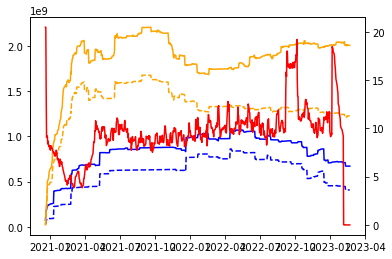

In [90]:
fig, axs = mp.subplots()
axs.plot(df_indexer_days_all.datestr,df_indexer_days_all.sum_stake, color='b')
axs.plot(df_indexer_days_top_all.datestr,df_indexer_days_top_all.sum_stake,color='b',linestyle='--')
axs.plot(df_indexer_days_all.datestr,df_indexer_days_all.sum_delegate, color='orange')
axs.plot(df_indexer_days_top_all.datestr,df_indexer_days_top_all.sum_delegate, color='orange',linestyle='--')
ax2=axs.twinx()
ax2.plot(df_indexer_days_all.datestr,get_rolling_avg(df_indexer_days_all.sum_rewards_all/1000000*30,30),color='r')
ax2.plot(df_indexer_days_top_all.datestr,get_rolling_avg(df_indexer_days_top_all.sum_rewards_all_usd/1000000*30,30),color='r',linestyle='--')
# ax2=axs.twinx()
# ax2.plot(df_indexer_days.datestr,df_indexer_days.num_indexers)

In [189]:
# considered timerange for rewards
start_date_rewards = datetime.strptime('2018-09-30','%Y-%m-%d')
end_date_rewards=datetime.strptime('2023-05-01','%Y-%m-%d')


In [190]:


df_indexer_data_all_usd = df_indexer_data_all[(df_indexer_data_all.datestr>start_date_rewards)&(df_indexer_data_all.datestr<end_date_rewards)].drop(columns='level_0').merge(df_grt_prices, how='left', left_on='datestr',right_on='datestr').reset_index()
df_indexer_data_all_usd['daily_rewards_indexer_usd']=df_indexer_data_all_usd.daily_indexer_rewards*df_indexer_data_all_usd.price
df_indexer_data_all_usd['daily_rewards_total_usd']=df_indexer_data_all_usd.daily_rewards_total*df_indexer_data_all_usd.price
#delegator rewards are off, likely outer join off somewhere
df_indexer_data_all_usd['daily_delegator_reward_usd']=df_indexer_data_all_usd.daily_rewards_total_usd-df_indexer_data_all_usd.daily_rewards_indexer_usd
df_indexer_data_all_usd['query_fees_usd']=df_indexer_data_all_usd.query_fees*df_indexer_data_all_usd.price
# df_indexer_data_all_usd['revenue_usd']=df_indexer_data_all_usd.rewards_indexer_usd+df_indexer_data_all_usd.fees_indexer_usd
df_indexer_data_all_usd['rebate_fees_usd']=df_indexer_data_all_usd.rebate_fees*df_indexer_data_all_usd.price

df_indexer_usd_grp = df_indexer_data_all_usd.groupby('indexer').agg(
    sum_rewards_usd=('daily_rewards_indexer_usd','sum'),
    sum_rewards=('daily_indexer_rewards','sum'),
    sum_rewards_total=('daily_rewards_total','sum'),
    sum_rewards_total_usd=('daily_rewards_total_usd','sum'),
    sum_query_fees_usd = ('query_fees_usd','sum'),
    sum_query_fees = ('query_fees','sum'), 
    sum_rebate_fees_usd = ('rebate_fees_usd','sum'),
    sum_rebate_fees = ('rebate_fees','sum'),
    sum_cost=('cost','sum')
).merge(df_indexer_all, how='inner',left_on='indexer',right_on='indexer').reset_index()

df_indexer_usd_grp['timeavg_indexer_rewards_usd']=df_indexer_usd_grp.sum_rewards_usd/df_indexer_usd_grp.days_active_total
df_indexer_usd_grp['timeavg_indexer_rewards']=df_indexer_usd_grp.sum_rewards/df_indexer_usd_grp.days_active_total
df_indexer_usd_grp['avg_price_rewards']=df_indexer_usd_grp.sum_rewards_usd/df_indexer_usd_grp.sum_rewards
avg_price = np.nansum(df_indexer_data_all_usd.daily_rewards_total_usd)/np.nansum(df_indexer_data_all_usd.daily_rewards_total)
df_indexer_usd_grp.loc[df_indexer_usd_grp.avg_price_rewards.isna(),'avg_price_rewards']=avg_price
# df_indexer_usd_grp['profit']=df_indexer_usd_grp.sum_revenue_usd-df_indexer_usd_grp.sum_cost
# df_indexer_usd_grp['profit_per_stake']=df_indexer_usd_grp.profit/df_indexer_usd_grp.time_weighted_stake

## 4) Monthly aggregation

In [187]:
lst_month_start=[
'2020-12-01',
'2021-01-01',
'2021-02-01',
'2021-03-01',
'2021-04-01',
'2021-05-01',
'2021-06-01',
'2021-07-01',
'2021-08-01',
'2021-09-01',
'2021-10-01',
'2021-11-01',
'2021-12-01',
'2022-01-01',
'2022-02-01',
'2022-03-01',
'2022-04-01',
'2022-05-01',
'2022-06-01',
'2022-07-01',
'2022-08-01',
'2022-09-01',
'2022-10-01',
'2022-11-01',
'2022-12-01',
'2023-01-01',
'2023-02-01',
'2023-03-01',
'2023-04-01'
]
lst_month_end = [
'2020-12-31',
'2021-01-31',
'2021-02-28',
'2021-03-31',
'2021-04-30',
'2021-05-31',
'2021-06-30',
'2021-07-31',
'2021-08-31',
'2021-09-30',
'2021-10-31',
'2021-11-30',
'2021-12-31',
'2022-01-31',
'2022-02-28',
'2022-03-31',
'2022-04-30',
'2022-05-31',
'2022-06-30',
'2022-07-31',
'2022-08-31',
'2022-09-30',
'2022-10-31',
'2022-11-30',
'2022-12-31',
'2023-01-31',
'2023-02-28',
'2023-03-31',
'2023-04-30'
]

In [39]:
num_month = 1
start_date_rewards = datetime.strptime(lst_month_start[num_month],'%Y-%m-%d')
end_date_rewards=datetime.strptime(lst_month_end[num_month],'%Y-%m-%d')



In [193]:
df_indexer_data_all_usd['year_month']=[str(df_indexer_data_all_usd.datestr.iloc[i].year)+'-' + str(df_indexer_data_all_usd.datestr.iloc[i].month)  for i in range(0, len(df_indexer_data_all_usd))]

In [194]:
df_monthly_data = df_indexer_data_all_usd.groupby('year_month').agg(
    sum_rewards_usd=('daily_rewards_indexer_usd','sum'),
    sum_rewards=('daily_indexer_rewards','sum'),
    sum_rewards_total=('daily_rewards_total','sum'),
    sum_rewards_total_usd=('daily_rewards_total_usd','sum'),
    sum_query_fees_usd = ('query_fees_usd','sum'),
    sum_query_fees = ('query_fees','sum'),
    # sum_rebate_fees_usd = ('rebate_fees_usd','sum'),
    # sum_rebate_fees = ('rebate_fees','sum'),
    sum_cost=('cost','sum'),
    num_indexer = ('indexer','nunique')
).reset_index()

In [195]:
df_monthly_data.to_csv('csvs/grt_monthly_rewards.csv')